<a href="https://colab.research.google.com/github/OmdenaAI/abakaliki-chapter-theft-churches-problem/blob/main/Naira_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To ensure that our dependencies and libraries needed for this project are are available and upto date
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_dir='/content/drive/MyDrive/sorted_data'
os.listdir(data_dir)

['#20', '#200', '#500', '#50', '#1000', '#10', '#100', '#5']

In [6]:
img_extension=['jpeg','jpg','png']

In [7]:
img_array=cv2.imread(os.path.join(data_dir,'#10', '10.jpg'))


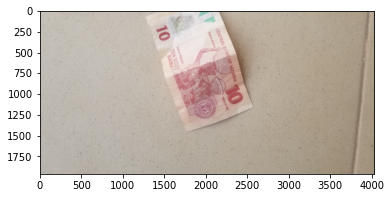

In [8]:
plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))

In [9]:
for img_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,img_class)):
    image_path = os.path.join(data_dir,img_class, image)
    try:
      img=cv2.imread(image_path)
      tip=imghdr.what(image_path)
      if tip not in img_extension:
        print('image {} does not have apt extension'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('{} ia a problematic file'.format(image_path))

In [10]:
# putting our cleaned data into keras and building our data pipeline
dataset= tf.keras.utils.image_dataset_from_directory(data_dir)
dataset

Found 488 files belonging to 8 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
#+for looping through our data pipeline or allowing access to data pipeline
data_iterator = dataset.as_numpy_iterator()

In [12]:
# actually accessing data pipeline
batch= data_iterator.next()

In [13]:
len(batch)

2

In [14]:
print(batch[0])
print(batch[1])

[[[[221.8711   220.8711   218.8711  ]
   [223.71289  222.71289  220.71289 ]
   [220.       220.       218.      ]
   ...
   [199.24414  190.24414  181.24414 ]
   [191.42383  182.42383  173.42383 ]
   [202.625    195.625    185.625   ]]

  [[223.88086  222.88086  220.88086 ]
   [224.01367  223.01367  221.01367 ]
   [219.87695  219.87695  217.87695 ]
   ...
   [202.9961   193.9961   184.9961  ]
   [200.24414  191.24414  182.24414 ]
   [204.37695  197.37695  187.37695 ]]

  [[221.35938  220.35938  218.35938 ]
   [223.60547  222.60547  220.60547 ]
   [220.68555  220.68555  218.68555 ]
   ...
   [202.49219  193.49219  184.49219 ]
   [200.03516  191.03516  182.03516 ]
   [201.69922  195.32422  184.07422 ]]

  ...

  [[217.40039  217.40039  217.40039 ]
   [216.08008  216.08008  216.08008 ]
   [218.08008  218.08008  218.08008 ]
   ...
   [186.00977  179.00977  163.00977 ]
   [190.06445  183.06445  167.06445 ]
   [191.61523  184.61523  165.99023 ]]

  [[218.99414  218.99414  218.99414 ]
   [212

In [15]:
print(batch[0].shape) # images represented as numpy array
print(batch[1].shape) #classes the images belong to

(32, 256, 256, 3)
(32,)


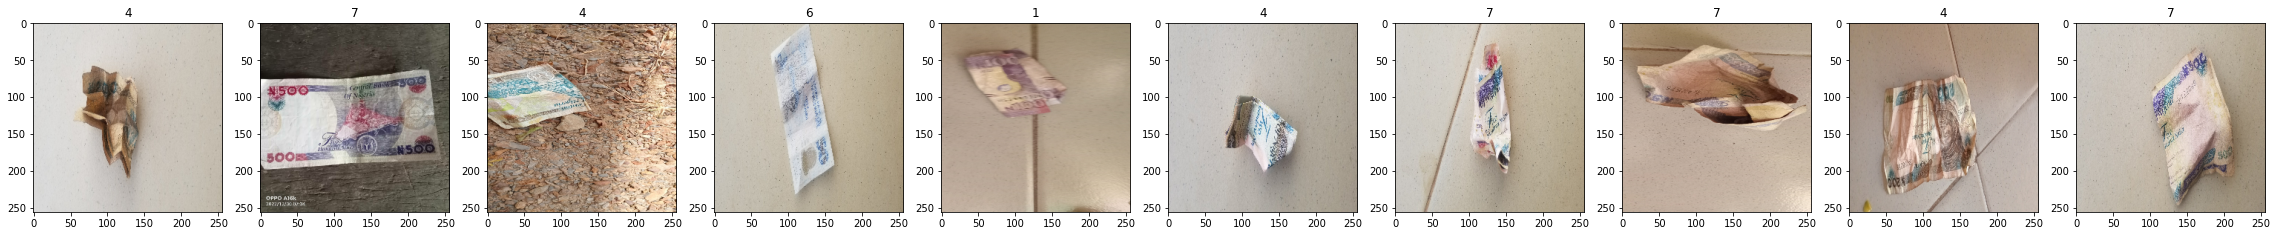

In [16]:
# to dictate which class represent a particular group of data
fig, ax = plt.subplots(ncols=10, figsize=(40,40))
for idx, img in enumerate(batch[0][:10]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [17]:
'''
0 = #10
1 = #100
2 = #1000
3 = #20
4 = #200
5 = #5
6 = #50
7 = #500
'''

'\n0 = #10\n1 = #100\n2 = #1000\n3 = #20\n4 = #200\n5 = #5\n6 = #50\n7 = #500\n'

# Data Preprocessing

In [18]:
scaled_data=dataset.map(lambda x, y: (x/255, y))
scaled_iterator= scaled_data.as_numpy_iterator()
scaled_batch= scaled_iterator.next()

In [19]:
print(scaled_batch[0].max())
print(scaled_batch[0].min())

1.0
0.0


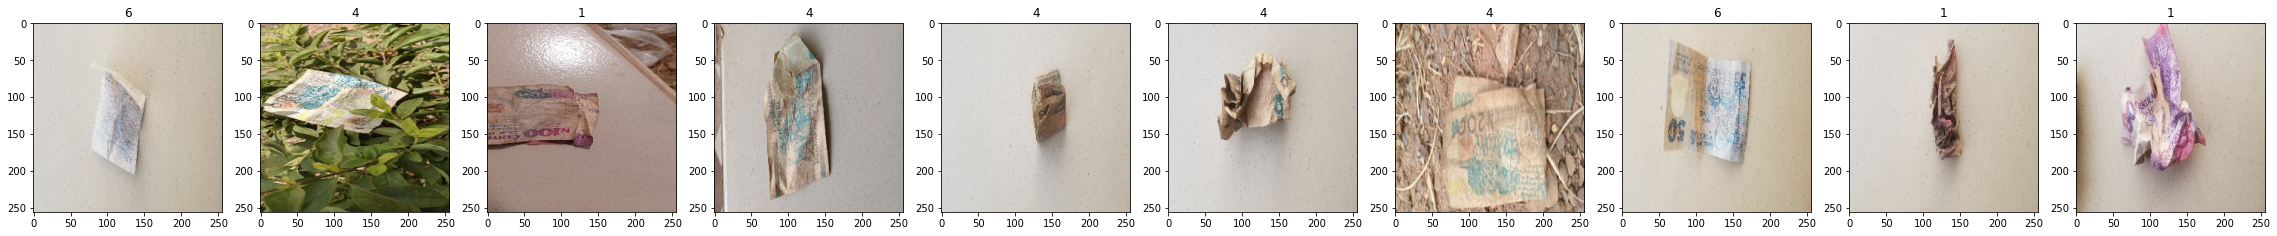

In [20]:
fig, ax = plt.subplots(ncols=10, figsize=(40,40))
for idx, img in enumerate(scaled_batch[0][:10]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(scaled_batch[1][idx])

In [21]:
len(scaled_data)

16

In [22]:
#splitting data into test, train and validation
train_size=int(len(scaled_data)*.625)
val_size=int(len(scaled_data)*.25)
test_size=int(len(scaled_data)*.125)

In [23]:
train=scaled_data.take(train_size)
val=scaled_data.skip(train_size).take(val_size)
test=scaled_data.skip(train_size+val_size).take(test_size)

# 2.0 Model Building

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential(
    [
        Conv2D(16,(3,3),1, activation='relu', input_shape=(256,256,3)),
        MaxPooling2D(),
     
        Conv2D(32,(3,3),1, activation='relu'),
        MaxPooling2D(),
     
        Conv2D(16,(3,3),1, activation='relu'),
        MaxPooling2D(),
        
        Flatten(),
     
        Dense(256, activation='relu'),
        Dense(8, activation='softmax')
    ]
)


In [26]:
model.compile('adam', loss= tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 2.1 Training

In [28]:
log_dir='/content/drive/MyDrive/logdir'

In [29]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

In [30]:
history = model.fit(train, epochs= 20, validation_data=val, callbacks= [tb_callback])

Epoch 1/20
10/10 [==============================] - 28s 1s/step - loss: 1.7490 - accuracy: 0.2531 - val_loss: 1.5360 - val_accuracy: 0.2578
Epoch 2/20
10/10 [==============================] - 20s 2s/step - loss: 1.4823 - accuracy: 0.3469 - val_loss: 1.4845 - val_accuracy: 0.2578
Epoch 3/20
10/10 [==============================] - 20s 2s/step - loss: 1.3855 - accuracy: 0.4125 - val_loss: 1.4426 - val_accuracy: 0.3984
Epoch 4/20
10/10 [==============================] - 20s 2s/step - loss: 1.3243 - accuracy: 0.4406 - val_loss: 1.2786 - val_accuracy: 0.4375
Epoch 5/20
10/10 [==============================] - 20s 2s/step - loss: 1.2164 - accuracy: 0.5469 - val_loss: 1.1805 - val_accuracy: 0.5703
Epoch 6/20
10/10 [==============================] - 20s 2s/step - loss: 1.1255 - accuracy: 0.5531 - val_loss: 1.1700 - val_accuracy: 0.5547
Epoch 7/20
10/10 [==============================] - 20s 2s/step - loss: 1.0398 - accuracy: 0.5969 - val_loss: 1.0141 - val_accuracy: 0.6484
Epoch 8/20
10/10 [==

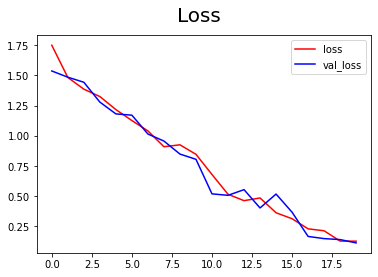

In [31]:
fig=plt.figure()
plt.plot(history.history['loss'], color='red', label= 'loss')
plt.plot(history.history['val_loss'], color='blue', label= 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

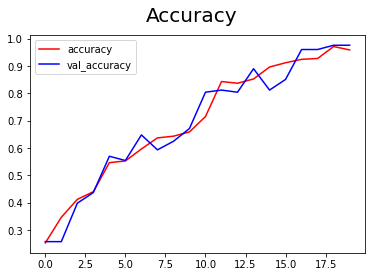

In [32]:
fig=plt.figure()
plt.plot(history.history['accuracy'], color='red', label= 'accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label= 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## 2.2 Evaluation

In [135]:
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score

In [136]:
yhat=[]
y_actual=[]
for batch in test.as_numpy_iterator():
    #for sets in batch:
    x, y = batch
    
    y_pred= model.predict(x)
    y_pred= np.argmax(y_pred,axis=1)
    y_pred= np.array(y_pred)
    
    yhat.append(y_pred)
    y_actual.append(y)

#y_pred=[np.argmax(value) for value in y_pred]     

1/1 [==============================] - 0s 18ms/step


In [137]:
yhat=np.append(yhat[0],yhat[1])
y_actual=np.append(y_actual[0],y_actual[1])

In [140]:
precision= precision_score(y_actual, yhat, average='weighted')
recall= recall_score(y_actual, yhat, average='weighted')
accuracy= accuracy_score(y_actual, yhat)

print(f'precision : {precision}, Recall : {recall}, Accuracy : {accuracy}')

precision : 0.9335227272727273, Recall : 0.95, Accuracy : 0.95


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
